In [42]:
# Packages 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [43]:
# Get data from yahoo finance
def fetch_data(ticker_symbol: str, interval: str = "1d") -> pd.DataFrame:
    """
    Retrieves historical data for a given stock symbol with a specified time interval.

    Args:
        ticker_symbol (str): The stock symbol to process.
        interval (str): Time interval between data points ('1h' for hourly, '1d' for daily, etc.).

    Returns:
        pd.DataFrame: A DataFrame containing the historical data.
    """
    ticker = yf.Ticker(ticker_symbol)
    # Adjust period to a smaller range for '1h' due to data volume
    data = ticker.history(period="max", interval=interval)  # Example for 60 days of hourly data
    data.index = data.index.tz_localize(None)
    return data

# Example usage:
# df = fetch_data("AAPL", "1h")


In [44]:
df_apple = fetch_data("MSFT", "1d")
df_apple.shape

(9612, 7)

In [45]:
# Analyse exploratoire des données
# Exploration des données
def explore_data(data : pd.DataFrame):
    """
    Perform initial data exploration including plotting and basic statistics.
    """
    # Affichage des premières lignes de données
    print("Head of the dataset:")
    print(data.head())

    # Affichage des dernières lignes de données
    print("Tail of the dataset:")
    print(data.tail())

    # Statistiques descriptives
    print("\nDescriptive Statistics:")
    print(data.describe())
    
    # Vérification des valeurs manquantes
    print("\nMissing values:")
    print(data.isnull().sum())

    # Visualisation de la série temporelle des prix de clôture
    plt.figure(figsize=(10, 4))
    plt.title("Closing Price Over Time")
    plt.plot(data['Close'])
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.show()
    
    # Histogramme des prix de clôture
    plt.figure(figsize=(6, 4))
    plt.title("Distribution of Close Prices")
    plt.hist(data['Close'], bins=30)
    plt.xlabel("Close Price")
    plt.ylabel("Frequency")
    plt.show()

Head of the dataset:
                Open      High       Low     Close      Volume  Dividends  \
Date                                                                        
1986-03-13  0.054792  0.062849  0.054792  0.060163  1031788800        0.0   
1986-03-14  0.060163  0.063386  0.060163  0.062311   308160000        0.0   
1986-03-17  0.062311  0.063923  0.062311  0.063386   133171200        0.0   
1986-03-18  0.063386  0.063923  0.061237  0.061774    67766400        0.0   
1986-03-19  0.061774  0.062311  0.060163  0.060700    47894400        0.0   

            Stock Splits  
Date                      
1986-03-13           0.0  
1986-03-14           0.0  
1986-03-17           0.0  
1986-03-18           0.0  
1986-03-19           0.0  
Tail of the dataset:
                  Open        High         Low       Close    Volume  \
Date                                                                   
2024-04-26  412.170013  413.000000  405.760010  406.320007  29694700   
2024-04-29  4

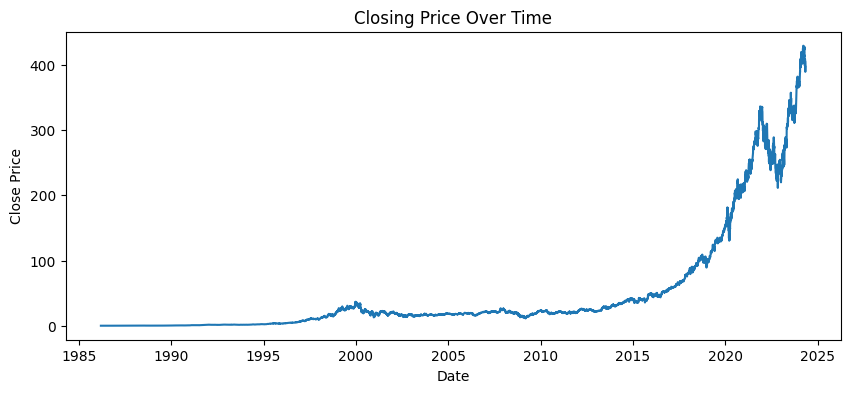

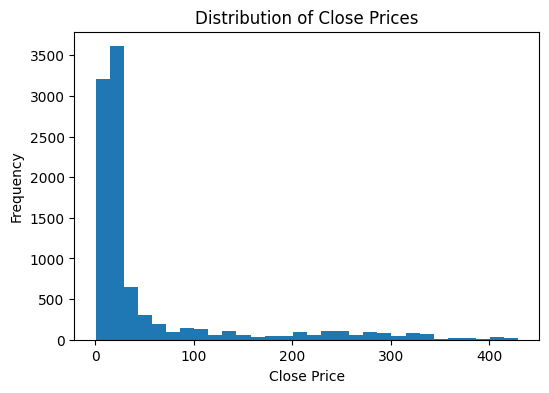

In [46]:
explore_data(df_apple)

In [47]:
# Nettoyage des données
def clean_data(data : pd.DataFrame):
    """
    Clean the data by filling or removing missing values.
    """
    # Gestion des valeurs manquantes
    # Option 1: Suppression des lignes avec des valeurs manquantes
    # data = data.dropna()

    # Option 2: Imputation (par exemple, remplissage par la dernière valeur connue)
    data = data.fillna(method='ffill')
    
    return data

In [48]:
cleaned_apple_data = clean_data(df_apple)

In [49]:
cleaned_apple_data.to_csv("./cleaned_data", index=True) 

# **UNE ERREUR QQ PART ICI

In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data, window_size=10):
    """
    Preprocess the data for CNN input, incorporating multiple feature columns.
    
    Args:
        data (pd.DataFrame): DataFrame containing the stock market data.
        window_size (int): The size of the sliding window to create subsequences.
    
    Returns:
        np.array: Preprocessed data ready for CNN input, scaler object for inverse transformation.
    """
    # Sélection des colonnes d'intérêt pour la prédiction
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[feature_columns]
    
    # Normalisation des données
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Création de séquences pour la fenêtre de temps
    X = []
    y = []
    
    for i in range(window_size, len(data_scaled)):
        X.append(data_scaled[i-window_size:i, :])  # Utiliser toutes les colonnes de features
        y.append(data_scaled[i, feature_columns.index('Close')])  # Prédiction basée sur la colonne 'Close'

    X, y = np.array(X), np.array(y)
    return X, y, scaler


In [51]:
data = pd.read_csv('./cleaned_data')  # Assurez-vous que le chemin et le fichier sont corrects
X, y, scaler = preprocess_data(data, window_size=20)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (9592, 20, 5)
Shape of y: (9592,)


In [52]:
# Division des données en ensembles d'entraînement, de validation, et de test

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (6714, 20, 5), (6714,)
Validation set: (1439, 20, 5), (1439,)
Test set: (1439, 20, 5), (1439,)


In [53]:
X_train.shape[1], X_train.shape[2]

(20, 5)

# **Amélioration du modèle**

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), 
           kernel_regularizer=l2(0.01)),  # Ajout de régularisation L2
    MaxPooling1D(pool_size=2),
    Dropout(0.2),  # Ajout de Dropout
    
    Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(100, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    
    Dense(1)
])

# Configuration de l'optimiseur avec un taux d'apprentissage ajusté
optimizer = Adam(learning_rate=0.001)  # Vous pouvez ajuster le learning rate ici
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [70]:
history = model.fit(
    X_train, y_train,
    epochs=100,  # Vous pouvez augmenter le nombre d'epochs
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/100
210/210 - 4s - 19ms/step - loss: 0.4496 - mae: 0.0281 - val_loss: 0.0143 - val_mae: 0.0141
Epoch 2/100
210/210 - 1s - 5ms/step - loss: 0.0100 - mae: 0.0262 - val_loss: 0.0067 - val_mae: 0.0119
Epoch 3/100
210/210 - 1s - 6ms/step - loss: 0.0079 - mae: 0.0268 - val_loss: 0.0062 - val_mae: 0.0239
Epoch 4/100
210/210 - 1s - 5ms/step - loss: 0.0072 - mae: 0.0255 - val_loss: 0.0057 - val_mae: 0.0133
Epoch 5/100
210/210 - 1s - 7ms/step - loss: 0.0072 - mae: 0.0265 - val_loss: 0.0058 - val_mae: 0.0193
Epoch 6/100
210/210 - 1s - 7ms/step - loss: 0.0067 - mae: 0.0248 - val_loss: 0.0054 - val_mae: 0.0207
Epoch 7/100
210/210 - 1s - 5ms/step - loss: 0.0067 - mae: 0.0263 - val_loss: 0.0055 - val_mae: 0.0184
Epoch 8/100
210/210 - 1s - 6ms/step - loss: 0.0062 - mae: 0.0240 - val_loss: 0.0053 - val_mae: 0.0265
Epoch 9/100
210/210 - 1s - 5ms/step - loss: 0.0066 - mae: 0.0268 - val_loss: 0.0053 - val_mae: 0.0196
Epoch 10/100
210/210 - 1s - 5ms/step - loss: 0.0063 - mae: 0.0262 - val_loss: 0.0

In [71]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

45/45 - 0s - 3ms/step - loss: 0.0035 - mae: 0.0117
Test Loss: 0.003496880177408457
Test MAE: 0.01167872454971075


In [85]:
# Faire des prédictions
predictions = model.predict(X_test)

# Assurez-vous que y_test et les prédictions sont de la même forme
predictions = predictions.flatten()  # Ajustez selon la sortie du modèle


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


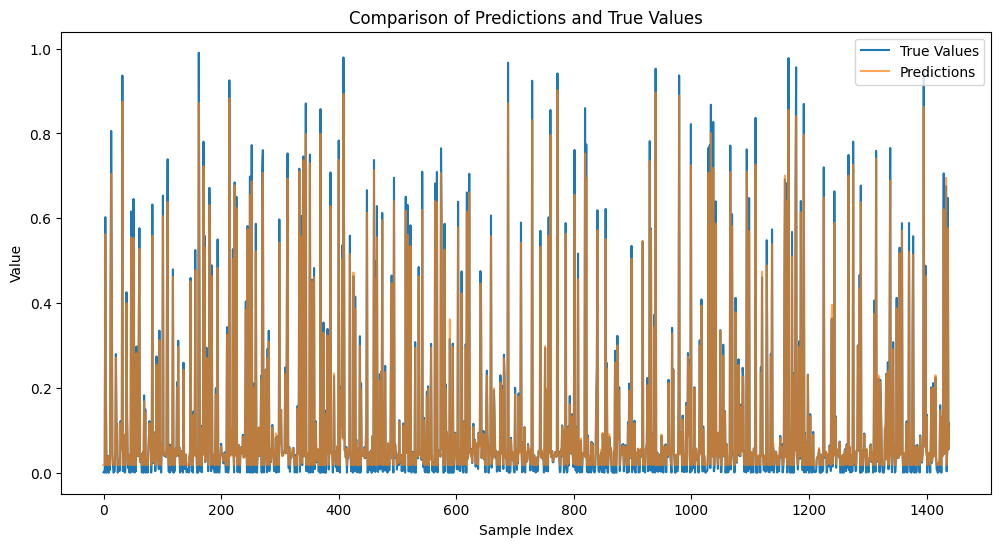

In [86]:
# Affichage des prédictions par rapport aux valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [87]:
# Afficher les valeurs prédites et les valeurs réelles
for i in range(len(predictions)):
    print(f"Prédiction: {predictions[i]}, Valeur Réelle: {y_test[i]}")

Prédiction: 0.018119890242815018, Valeur Réelle: 0.0011911687069001236
Prédiction: 0.018181033432483673, Valeur Réelle: 0.003255694857645924
Prédiction: 0.018115155398845673, Valeur Réelle: 0.00019519044826201917
Prédiction: 0.5621513724327087, Valeur Réelle: 0.6026425061244103
Prédiction: 0.19329702854156494, Valeur Réelle: 0.19787528887723457
Prédiction: 0.018116947263479233, Valeur Réelle: 3.8788419247047826e-05
Prédiction: 0.01909785345196724, Valeur Réelle: 0.008619705867414567
Prédiction: 0.018970005214214325, Valeur Réelle: 0.007730080634472536
Prédiction: 0.0382823571562767, Valeur Réelle: 0.039756519601933375
Prédiction: 0.018116705119609833, Valeur Réelle: 2.502442356368983e-05
Prédiction: 0.0391402393579483, Valeur Réelle: 0.0363556618663972
Prédiction: 0.018749985843896866, Valeur Réelle: 0.00636749693475854
Prédiction: 0.40515604615211487, Valeur Réelle: 0.4517203489043789
Prédiction: 0.704603910446167, Valeur Réelle: 0.8058555908357837
Prédiction: 0.46338972449302673, Val

In [82]:

predictions.shape

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([1.19116871e-03, 3.25569486e-03, 1.95190448e-04, ...,
       6.47942025e-01, 5.47307928e-02, 1.15676431e-01])

In [78]:
# Supposons que 'predictions' et 'y_test' sont vos prédictions et valeurs réelles normalisées du 'Close'
# et 'scaler' est votre MinMaxScaler qui a été ajusté aux données y compris 'Close'

# Préparer les matrices pour la dénormalisation
# Nous utilisons une méthode simplifiée ici en assumant que vous avez conservé le scaler spécifique pour 'Close'
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Sauvegarder les résultats dénormalisés dans un CSV pour analyse

results = pd.DataFrame({
    "Predicted_Close": predicted_prices.flatten(),  # Aplatir les arrays pour éviter des erreurs de forme
    "Real_Close": real_prices.flatten()
})

results.to_csv("./predicted_vs_real_close.csv", index=False)
print("Predicted vs Real Close prices saved to 'predicted_vs_real_close.csv'")


ValueError: non-broadcastable output operand with shape (1439,1) doesn't match the broadcast shape (1439,5)